In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarnin

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [3]:
class gNN:
    def __init__(self, x, u, u_deri, layers, activation, lr, weight_g):
        self.x = x
        self.u = u
        self.u_deri = u_deri
        self.lr = lr
        self.activation = activation
        self.weight_g = weight_g
        self.loss_log = []
        self.loss_res_log = []
        self.loss_deriv_log = []

        self.weights, self.biases = self.initilize_NN(layers)
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.u_deriv_tf = tf.placeholder(tf.float32, shape=[None, self.u_deri.shape[1]])

        self.u_pred = self.net_u(self.x_tf)
        self.u_deri_pred = self.u_deriv(self.u_pred, self.x_tf)

        self.loss_res   = tf.reduce_mean(tf.square(self.u_tf - self.u_pred))
        self.loss_deriv = tf.reduce_mean(tf.square(self.u_deriv_tf - self.u_deri_pred))
        self.loss       = self.loss_res + self.weight_g*self.loss_deriv

        steps_per_decay = 1000
        decay_factor = 0.9
        self.global_step = tf.Variable(0, trainable=False)
        self.lr = tf.train.exponential_decay(learning_rate = lr,
                                           global_step = self.global_step,
                                           decay_steps = steps_per_decay,
                                           decay_rate = decay_factor,
                                           staircase = True
                                           )
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss,
                                            global_step=self.global_step)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initilize_NN(self, layers):
        weights = []
        biases  = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases, activation):
        num_layers = len(weights) + 1
        H = X
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = activation(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x):
        u = self.neural_net(x, self.weights, self.biases, self.activation)
        return u

    def u_deriv(self, u, x):
        u_x = tf.gradients(u, x)[0]
        return u_x

    def callback(self, loss, res, deriv):
        print('Loss:%f,res:%f,deriv:%f'%(loss, res, deriv))

    def train(self, max_iter=40000):
        loss_value = np.inf
        for iter in range(max_iter):
            self.sess.run(self.global_step)
            tf_dict = {
                self.x_tf:self.x,
                self.u_tf:self.u,
                self.u_deriv_tf:self.u_deri
            }
            _, loss_value, lo, lo_deriv = self.sess.run([self.optimizer,
                self.loss, self.loss_res, self.loss_deriv], tf_dict)
            self.sess.run(self.lr)
            if iter % 2000 == 0:
                print("第%d次 %f,res %f,deriv %f"%(iter, loss_value, lo, lo_deriv))
        print("第%d次的损失为%f"%(max_iter, loss_value))
        print("最终lr为%f"%(self.sess.run(self.lr)))

    def predict(self, X_star):
        u_star = self.sess.run(self.u_pred, {self.x_tf: X_star})
        return u_star

In [4]:
layers = [1, 20, 20, 20, 20, 1]
activation = tf.tanh
lr = 1e-3
weight_g = 0.1
iterations = 10000

In [5]:
def train_model(train_num):
    x = np.linspace(0, 1, train_num)[:, None]
    u = -(1.4-3*x)*np.sin(18*x)
    u_deriv = 3*np.sin(18*x) - (1.4-3*x)*18*np.cos(18*x)
    start_time = time.time()
    gNN_tanh = gNN(x, u, u_deriv, layers, activation, lr, weight_g)
    print("Start training! train_num:%d"%(train_num))
    gNN_tanh.train(iterations)
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))
    return gNN_tanh

In [6]:
def compute_error(model, test_num):
    x_test   = np.linspace(0, 1, test_num)[:, None]
    u_test   = -(1.4-3*x_test)*np.sin(18*x_test)
    u_pred   = model.predict(x_test)
    L2_norm  = np.linalg.norm(u_test-u_pred,2)/np.linalg.norm(u_test,2)
    return L2_norm

In [7]:
train_nums = np.arange(5, 31, 1)
test_num   = 1000
errors     = []
for train_num in train_nums:
    model = train_model(train_num)
    error = compute_error(model, test_num)
    print("train_num:%d, error:%f"%(train_num, error))
    errors.append(error)

Start training! train_num:5
第0次 21.512825,res 0.485205,deriv 210.276199
第2000次 0.000000,res 0.000000,deriv 0.000000
第4000次 0.000000,res 0.000000,deriv 0.000000
第6000次 0.000000,res 0.000000,deriv 0.000004
第8000次 0.000001,res 0.000000,deriv 0.000005
第10000次的损失为0.000000
最终lr为0.000349
Training time: 29.8202
train_num:5, error:0.388964
Start training! train_num:6
第0次 18.330145,res 0.443336,deriv 178.868088
第2000次 0.000000,res 0.000000,deriv 0.000000
第4000次 0.000000,res 0.000000,deriv 0.000000
第6000次 0.000001,res 0.000000,deriv 0.000008
第8000次 0.000000,res 0.000000,deriv 0.000000
第10000次的损失为0.002375
最终lr为0.000349
Training time: 29.5429
train_num:6, error:0.191889
Start training! train_num:7
第0次 21.246063,res 0.273608,deriv 209.724533
第2000次 0.013452,res 0.012494,deriv 0.009586
第4000次 0.000000,res 0.000000,deriv 0.000000
第6000次 0.000000,res 0.000000,deriv 0.000003
第8000次 0.000291,res 0.000003,deriv 0.002873
第10000次的损失为0.000000
最终lr为0.000349
Training time: 30.4271
train_num:7, error:0.145917
S

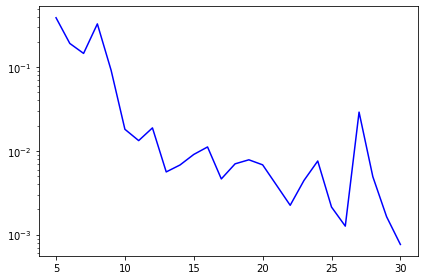

In [8]:
errors = np.array(errors)
plt.plot(train_nums, errors, 'b-')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [9]:
np.save('errors.npy', errors)

In [10]:
weight_g = 0.01

Start training! train_num:5
第0次 2.547623,res 0.442225,deriv 210.539795
第2000次 0.000005,res 0.000005,deriv 0.000061
第4000次 0.000000,res 0.000000,deriv 0.000000
第6000次 0.000000,res 0.000000,deriv 0.000015
第8000次 0.000155,res 0.000033,deriv 0.012228
第10000次的损失为0.000028
最终lr为0.000349
Training time: 34.1053
train_num:5, error:0.596332
Start training! train_num:6
第0次 2.285063,res 0.491443,deriv 179.361984
第2000次 0.000156,res 0.000146,deriv 0.000964
第4000次 0.000000,res 0.000000,deriv 0.000000
第6000次 0.000035,res 0.000027,deriv 0.000804
第8000次 0.000000,res 0.000000,deriv 0.000000
第10000次的损失为0.000000
最终lr为0.000349
Training time: 34.4934
train_num:6, error:0.177567
Start training! train_num:7
第0次 2.395401,res 0.290073,deriv 210.532822
第2000次 0.000000,res 0.000000,deriv 0.000000
第4000次 0.000368,res 0.000082,deriv 0.028649
第6000次 0.000000,res 0.000000,deriv 0.000000
第8000次 0.000000,res 0.000000,deriv 0.000001
第10000次的损失为0.000049
最终lr为0.000349
Training time: 34.4353
train_num:7, error:0.299706
Star

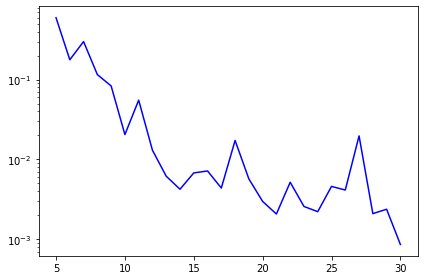

In [11]:
errors     = []
for train_num in train_nums:
    model = train_model(train_num)
    error = compute_error(model, test_num)
    print("train_num:%d, error:%f"%(train_num, error))
    errors.append(error)

errors = np.array(errors)
plt.plot(train_nums, errors, 'b-')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [12]:
np.save('errors.npy', errors)